# Generate Dataset: Lips Mask

  This dataset will be using mediapipe to create a mask of the lips which will then be used to create the dataset. For the dataset, it will be taken from a public kaggle repository. 

  If you want, you can use other repositories as the initial basis of the dataset generation.

## Our lips segmentation dataset


  The dataset link from kaggle: 

      https://www.kaggle.com/datasets/olekslu/makeup-lips-segmentation-28k-samples



In [1]:
# Please Note that the packages imported here are not necessarily needed.
# It's just that I can't be bothered to check which one is needed


# Install the segmentation model of pytorch
!pip install segmentation-models-pytorch

# Install kaggle to google colab
!pip install -q kaggle

# Import necessary models
import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2


# Make kaggle directory
!mkdir /kaggle

# Mount the google drive
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.4 MB/s 
     |████████████████████████████████| 376 kB 41.6 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=9abe792a220f96ae3b94507ed9ed7d61f563c3d9a4073d357cb12923cd42d7a1
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=93b3e07b779f5d76ee363f6fc163a57bdfc8a8879498d37c499ca6201d9522a5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Mounted at /content/drive


In [2]:
# Upload the kaggle.json
files.upload()
!ls -lha kaggle.json


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!pwd
# Download the lips segmentation dataset and
# Unzip the it
!kaggle datasets download -d ashwingupta3012/male-and-female-faces-dataset
!unzip /content/male-and-female-faces-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Male and Female face dataset/Female Faces/0 (1367).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1368).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1369).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (137).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1370).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1371).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1372).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1373).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1374).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1375).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1376).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1377).jpg  
  inflating: Male and Female face dataset/Female Faces/0 (1378).jpg  
  inflating: Male and Female face datase

In [3]:
# Import tensorflow
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
from glob import glob

In [4]:
# Path of the lips segmentation dataset
DATASET_FILEPATH = Path('/content/Male and Female face dataset/')

# Folder for the original image
FEMALE = 'Female Faces/'

# Folder for the mask image
MALE = 'Male Faces/'

class_names = [ "Female", "Male" ]

# File path for the folders
FEMALE_FILEPATH = DATASET_FILEPATH.joinpath(FEMALE)
MALE_FILEPATH = DATASET_FILEPATH.joinpath(MALE)

In [5]:
# Check Path
print( FEMALE_FILEPATH )
print( MALE_FILEPATH)

/content/Male and Female face dataset/Female Faces
/content/Male and Female face dataset/Male Faces


In [6]:
# Read the paths of the files inside the folder
female_images = sorted(glob(os.path.join(DATASET_FILEPATH, "Female Faces/*")))
male_images = sorted(glob(os.path.join(DATASET_FILEPATH, "Male Faces/*")))

In [7]:
# Count how many files are present in each folder
print( len(female_images))
print( len(male_images))

2698
2720


In [8]:
# Cut some files to make the distribution even
female_images = np.delete( female_images, np.arange( 2698, 2698, 1))
male_images = np.delete( male_images, np.arange( 2698, 2720, 1))

In [9]:
# Check the distribution
print( len(female_images))
print( len(male_images))

2698
2698


In [10]:
# Check if the files matches
print( male_images[100])
print( female_images[100])

/content/Male and Female face dataset/Male Faces/1 (1085).jpg
/content/Male and Female face dataset/Female Faces/0 (1085).jpg


## Create Mask

In [11]:
# Install these if it is not yet installed
!pip install numpy
!pip install mediapipe
!pip install importlib-metadata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.5 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
# Imports
import cv2
import numpy as np
import mediapipe as mp
from time import time
import matplotlib.pyplot as plt

In [13]:
# Initialize the mediapipe face mesh class.
mp_face_mesh = mp.solutions.face_mesh

# Set up the face landmarks function for images.
face_mesh_images = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=2,
                                         refine_landmarks=True, min_detection_confidence=0.5)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils

# Initialize the mediapipe drawing styles class.
mp_drawing_styles = mp.solutions.drawing_styles

In [14]:
# These are the landmark ids of the facial features that we want to target
# In this case, it is the lips. 

# To know the configuration of the landmarks, refer to mediapipe's documentation

# Initialize a list to store the indexes of the upper lips outer outline landmarks.
lips_upper_outer_ids = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291]

# Initialize a list to store the indexes of the lower lips outer outline landmarks.
lips_lower_outer_ids = [61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291]

# Initialize a list to store the indexes of the upper lips inner outline landmarks.
lips_upper_inner_ids = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308]

# Initialize a list to store the indexes of the lower lips inner outline landmarks.
lips_lower_inner_ids = [324, 318, 402, 317, 14, 87, 178, 88, 95, 78]

In [15]:
def detectFacialLandmarks(image, face_mesh, draw=True, display = True):
    '''
    This function performs facial landmarks detection on an image.
    Args:
        image:     The input image of person(s) whose facial landmarks needs to be detected.
        face_mesh: The Mediapipe's face landmarks detection function required to perform the landmarks detection.
        draw:      A boolean value that is if set to true the function draws Face(s) landmarks on the output image. 
        display:   A boolean value that is if set to true the function displays the original input image, 
                   and the output image with the face landmarks drawn and returns nothing.
    Returns:
        output_image:   A copy of input image with face landmarks drawn.
        face_landmarks: An array containing the face landmarks (x and y coordinates) of a face in the image.
    '''
    
    # Get the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize an array to store the face landmarks.
    face_landmarks = np.array([])
    
    # Create a copy of the input image to draw facial landmarks.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the facial landmarks detection on the image.
    results = face_mesh.process(imgRGB)
    
    # Check if facial landmarks are found. 
    if results.multi_face_landmarks:

        # Iterate over the found faces.
        for face in results.multi_face_landmarks:
            
            # Convert the Face landmarks x and y coordinates into their original scale,
            # And store them into a numpy array.
            # For simplicity, we are only storing face landmarks of a single face, 
            # you can extend it to work with multiple faces if you want.
            face_landmarks = np.array([(landmark.x*width, landmark.y*height)
                                        for landmark in face.landmark], dtype=np.int32)
            
            # Check if facial landmarks are specified to be drawn.
            if draw:

                # Draw the facial landmarks on the output image with the face mesh tesselation
                # connections using default face mesh tesselation style.
                mp_drawing.draw_landmarks(image=output_image, landmark_list=face,
                                          connections=mp_face_mesh.FACEMESH_TESSELATION,
                                          landmark_drawing_spec=None, 
                                          connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())

                # Draw the facial landmarks on the output image with the face mesh contours
                # connections using default face mesh contours style.
                mp_drawing.draw_landmarks(image=output_image, landmark_list=face,
                                          connections=mp_face_mesh.FACEMESH_CONTOURS,
                                          landmark_drawing_spec=None, 
                                          connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style())

    # Check if the original input image and the output image are specified to be displayed.
    if display:
        
        # Display the original input image and the output image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Sample Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    # Otherwise
    else:
        
        # Return the output image and landmarks returned by the detector.
        return output_image, face_landmarks

In [16]:
def getLipsMask(image, face_landmarks,  display=True):
    '''
    This function will generate a face part mask image utilizing face landmarks.
    Args:
        image:          The image of the face whose face part mask image is required.
        face_landmarks: An array containing the face landmarks (x and y coordinates) of the face in the image.
        display:        A boolean value that is if set to true the function displays the face image, 
                        and the generated face part mask image and returns nothing.
    Returns:
        mask: The face part mask image with values 255 at the specified face part region and 0 at the remaining regions.
    '''
    
    # Get the height and width of the face image.
    height, width, _ = image.shape
    
    # Initialize a list to store the lips landmarks.
    lips_landmarks = []

    # Initialize a list to store the mouth landmarks.
    mouth_landmarks= []
    
    # Iterate over the indexes of the upper and lower lips outer outline.
    for index in lips_upper_outer_ids+lips_lower_outer_ids:
        # Get the landmark at the index we are iterating upon,
        # And append it into the list.
        lips_landmarks.append(face_landmarks[index])
    
    # Iterate over the indexes of the upper and lower lips innner outline.   
    for index in lips_upper_inner_ids+lips_lower_inner_ids:
        # Get the landmark at the index we are iterating upon,
        # And append it into the list.
        mouth_landmarks.append(face_landmarks[index])

    # Initialize a black empty canvas to draw the face part(s) on.
    mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Draw (white) filled lips contours on the mask (black canvas).
    cv2.drawContours(mask, contours=[np.int32(lips_landmarks)], contourIdx=-1, 
                      color=(255, 255, 255), thickness=-1)  

    # Remove mouth area from the mask by drawing filled mouth contours with black color.
    cv2.drawContours(mask, contours=[np.array(mouth_landmarks, np.int32)], contourIdx=-1, 
                      color=(0, 0, 0), thickness=-1)    
        
    # Check if the original input image and the generated mask image are specified to be displayed.
    if display:
        # Display the original input image and the generated mask image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Sample Image");plt.axis('off');
        plt.subplot(122);plt.imshow(mask);plt.title("Output Image");plt.axis('off');
        return mask
    # Otherwise
    else: 
        # Return the face part mask image with values 255 at the specified face part region.
        return mask

In [17]:
# Initialize stats
fail_count = 0
success_count = 0
savedImages_count = 0

# Initialize where the generated dataset will be stored
NEW_PATH = "/content/Lips_Dataset/"
NEW_ORIGINAL_PATH = NEW_PATH + "original/"
NEW_MASK_PATH = NEW_PATH + "mask/"


# Just change the number of iteration depending on the size of your initial repository
for i in range( 2698 ):
  try:
    read_female = cv2.imread(female_images[i])
    female_image, female_face_landmarks = detectFacialLandmarks(read_female, face_mesh_images, draw=False, display=False)
    female_lips_mask = getLipsMask(female_image, female_face_landmarks, display=False)

    read_male = cv2.imread(male_images[i])
    male_image, male_face_landmarks = detectFacialLandmarks(read_male, face_mesh_images, draw=False, display=False)
    male_lips_mask = getLipsMask( male_image, male_face_landmarks, display=False)


    cv2.imwrite( NEW_ORIGINAL_PATH + "original_{}.jpg".format( savedImages_count ) , female_image)
    cv2.imwrite( NEW_MASK_PATH + "mask_{}.jpg".format( savedImages_count ) , female_lips_mask)
    savedImages_count += 1

    cv2.imwrite(NEW_ORIGINAL_PATH + "original_{}.jpg".format( savedImages_count ) , male_image)
    cv2.imwrite( NEW_MASK_PATH + "mask_{}.jpg".format( savedImages_count ) , male_lips_mask)
    savedImages_count += 1

    success_count += 1
  except:
    fail_count += 1


In [18]:
# Check stats
print( fail_count )
print( success_count )
print( savedImages_count)

165
2533
5066


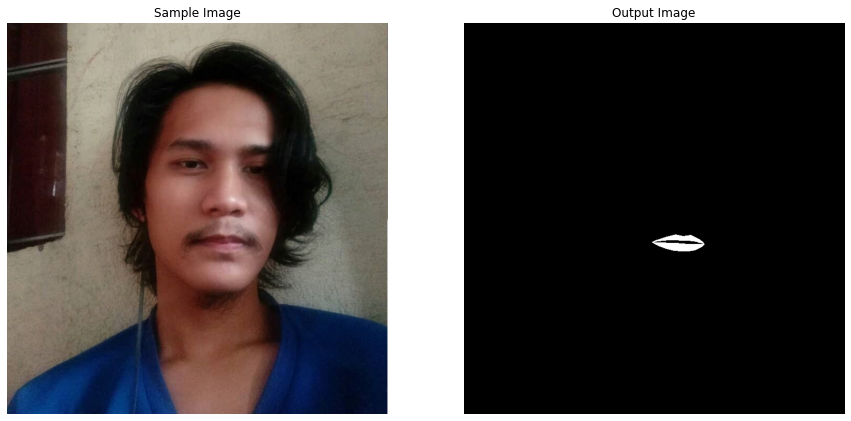

In [19]:
 # Read a sample image and apply lipstick on the face in the image.
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Faces/Rahms.jpg')
image, face_landmarks = detectFacialLandmarks(image, face_mesh_images, draw=False, display=False)
lips_mask = getLipsMask(image, face_landmarks, display=True)

In [22]:
print( "Mask Shape: ",  male_lips_mask.shape )
print( "Original Image Shape: ", male_image.shape)

Mask Shape:  (1920, 1280, 3)
Original Image Shape:  (1920, 1280, 3)


In [21]:
 # If you want to compress the dataset that you have generated, use this
 !zip -r /content/drive/MyDrive/Lips_Dataset.zip Lips_Dataset/


zip error: Nothing to do! (try: zip -r /content/drive/MyDrive/Lips_Dataset.zip . -i Lips_Dataset/)
